## Bitcoin Cryptocurrency Prediction using Tensorflow and LSTM

### CSX 433.7 Machine Learning with Tensorflow Final Project

**Alison Jing Huang**

**Elaine Phan**

# Part 3 Machine Learning with Tensorflow using Long Short Term Memory

## 0. Import necessary libraries for the analysis 

In [1]:
import json
import requests

import pandas as pd
import time
import seaborn as sns
import datetime
import numpy as np
from math import sqrt
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation, Dense
from keras.layers import Dropout

from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.offline as py
cf.go_offline()

sns.set_palette('Set2')
%matplotlib inline

/Users/Jing/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## 1. Data Import using API and Json 

In [2]:
# Extract the run-time data from crpyocompare data
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
BTCdata = pd.DataFrame(json.loads(res.content)['Data'])
BTCdata = BTCdata.set_index('time')
BTCdata.index = pd.to_datetime(BTCdata.index, unit='s')

In [3]:
# There are 2001 records of the Bitcoin price on API
BTCdata.describe()

,close,high,low,open,volumefrom,volumeto
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000,2.001000e+03
mean,1829.946187,1895.458621,1747.220490,1826.903763,63448.015837,1.964340e+08
std,3247.142500,3383.907120,3069.246454,3246.006135,60019.074205,4.915667e+08
min,13.440000,13.520000,13.310000,13.440000,404.380000,1.714970e+05
25%,252.600000,258.870000,244.470000,252.330000,22665.100000,5.817810e+06
50%,478.490000,493.260000,467.050000,478.380000,48422.160000,1.789079e+07
75%,1041.900000,1067.700000,1000.410000,1037.910000,86127.280000,7.029834e+07
max,19345.490000,19870.620000,18750.910000,19346.600000,572349.320000,6.245732e+09


In [4]:
# Check the earlies 10 days of the historical dataset
BTCdata.head(10)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2013-01-05,13.44,13.55,13.31,13.50,21329.93,286932.51
2013-01-06,13.45,13.52,13.36,13.44,12741.13,171497.01
2013-01-07,13.59,13.59,13.40,13.45,25477.72,344083.33
2013-01-08,13.74,13.88,13.50,13.59,42798.37,587223.86
2013-01-09,13.77,13.86,13.62,13.74,28606.38,393192.24
2013-01-10,14.14,14.32,13.77,13.77,51811.03,727790.48
2013-01-11,14.14,14.35,13.91,14.14,40434.54,570677.27
2013-01-12,14.24,14.34,13.98,14.14,26931.84,381546.96
2013-01-13,14.12,14.31,13.95,14.24,38330.15,540759.58


In [5]:
# Plot the Bitcoin Price and Volume trend in January, 2013
BTCdata.head(20).iplot()

In [6]:
# check the data of the last 6 days
BTCdata.tail(5)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2018-06-24,6157.78,6254.02,5782.13,6166.36,110833.06,6.674791e+08
2018-06-25,6260.35,6344.45,6095.25,6157.78,79086.40,4.928342e+08
2018-06-26,6088.39,6286.36,6067.49,6260.40,62925.30,3.913967e+08
2018-06-27,6141.57,6192.11,6021.69,6092.26,62639.82,3.834571e+08
2018-06-28,6107.65,6172.23,6107.65,6141.57,4034.43,2.490362e+07


In [7]:
# Plot the most current 40 days trend of Bitcoin price and volumes
BTCdata.tail(40).iplot()

## 2. Training -Test Dataset Split with 80/20 

In [8]:
target_col = 'close'

In [9]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(BTCdata, test_size=0.2)

In [10]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2, ):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw, color='blue')
    ax.plot(line2, label=label2, linewidth=lw, color='green')
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

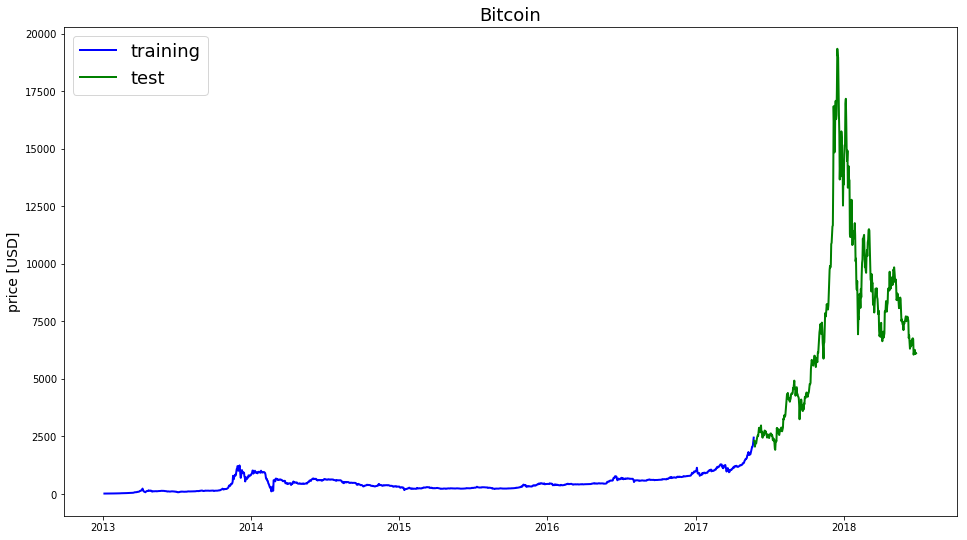

In [11]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='Bitcoin')

## 3.  Build the LSTM Model

In [12]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())

In [13]:
def extract_window_data(df, window_len=10, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [14]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [15]:
def BTC_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [16]:
np.random.seed(100)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# define the model parameterss
lstm_neurons = 20
epochs = 100
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [17]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    BTCdata, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [18]:
model = BTC_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/100
 - 5s - loss: 0.0827
Epoch 2/100
 - 4s - loss: 0.0545
Epoch 3/100
 - 4s - loss: 0.0483
Epoch 4/100
 - 6s - loss: 0.0441
Epoch 5/100
 - 5s - loss: 0.0423
Epoch 6/100
 - 5s - loss: 0.0405
Epoch 7/100
 - 5s - loss: 0.0396
Epoch 8/100
 - 7s - loss: 0.0404
Epoch 9/100
 - 4s - loss: 0.0398
Epoch 10/100
 - 4s - loss: 0.0385
Epoch 11/100
 - 4s - loss: 0.0383
Epoch 12/100
 - 4s - loss: 0.0380
Epoch 13/100
 - 4s - loss: 0.0380
Epoch 14/100
 - 5s - loss: 0.0373
Epoch 15/100
 - 4s - loss: 0.0374
Epoch 16/100
 - 4s - loss: 0.0366
Epoch 17/100
 - 4s - loss: 0.0367
Epoch 18/100
 - 4s - loss: 0.0375
Epoch 19/100
 - 4s - loss: 0.0368
Epoch 20/100
 - 4s - loss: 0.0381
Epoch 21/100
 - 4s - loss: 0.0375
Epoch 22/100
 - 4s - loss: 0.0368
Epoch 23/100
 - 5s - loss: 0.0367
Epoch 24/100
 - 4s - loss: 0.0373
Epoch 25/100
 - 4s - loss: 0.0371
Epoch 26/100
 - 4s - loss: 0.0373
Epoch 27/100
 - 4s - loss: 0.0362
Epoch 28/100
 - 4s - loss: 0.0361
Epoch 29/100
 - 5s - loss: 0.0368
Epoch 30/100
 - 6s - lo

In [19]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

In [20]:
mean_absolute_error(preds, y_test)

0.03974061564377787

In [21]:
mean_squared_error(preds, y_test)

0.002805792621466888

In [22]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________
None


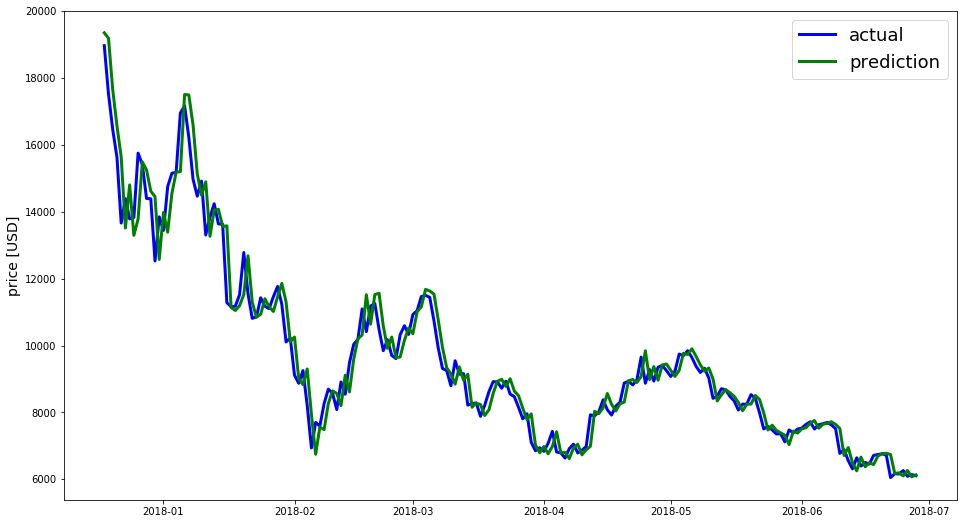

In [23]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction', lw=3)


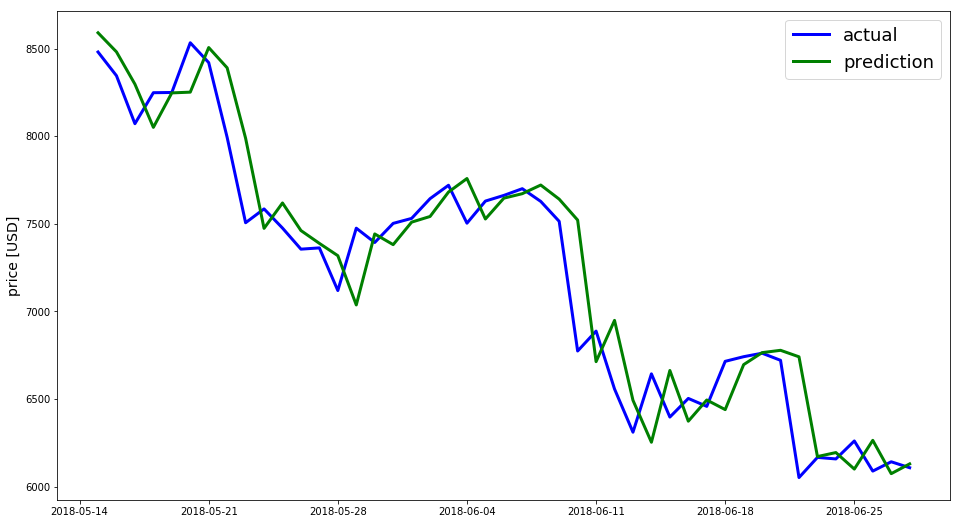

In [24]:
n_points = 45

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

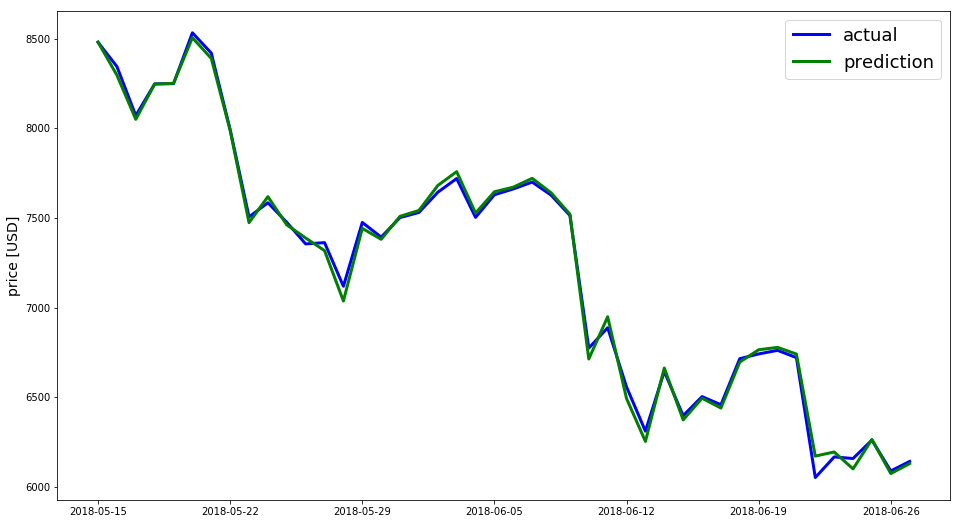

In [25]:
line_plot(targets[-n_points:][:-1], preds[-n_points:].shift(-1), 'actual', 'prediction', lw=3)

In [26]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

In [27]:
def dual_line_plot(line1, line2, line3, line4, label1=None, label2=None, title='', lw=2):
    import matplotlib.dates as mdates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))
    ax1.plot(line1, label=label1, linewidth=lw, color="black")
    ax1.plot(line2, label=label2, linewidth=lw, color="tomato")
    ax2.plot(line3, label=label1, linewidth=lw, color="black")
    ax2.plot(line4, label=label2, linewidth=lw, color="tomato")
    ax2.set_xticks(ax1.get_xticks())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.set_ylabel('daily returns', fontsize=14)
    ax2.legend(loc='best', fontsize=18);

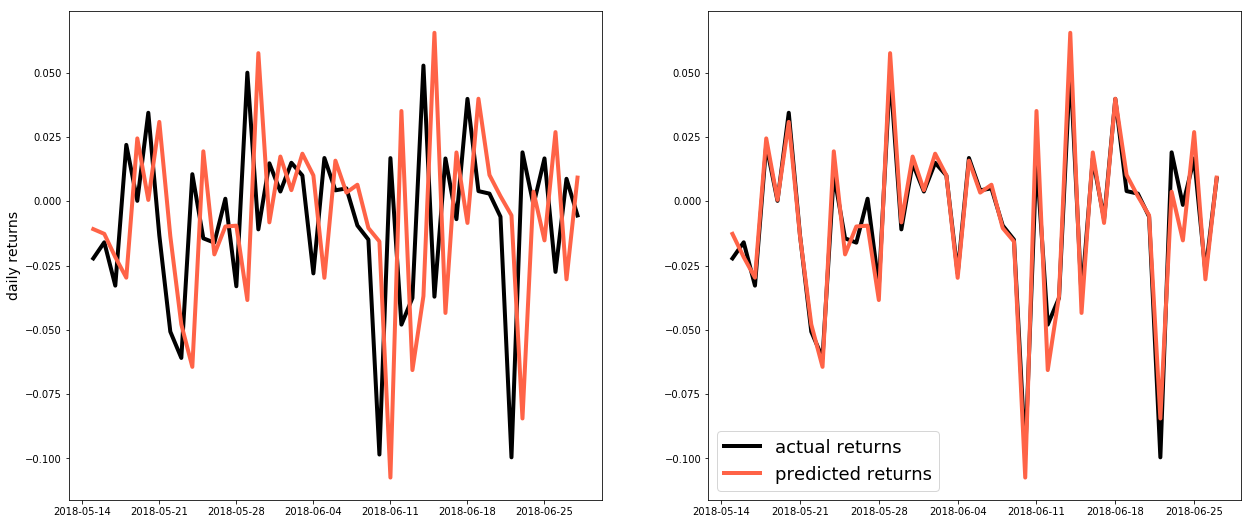

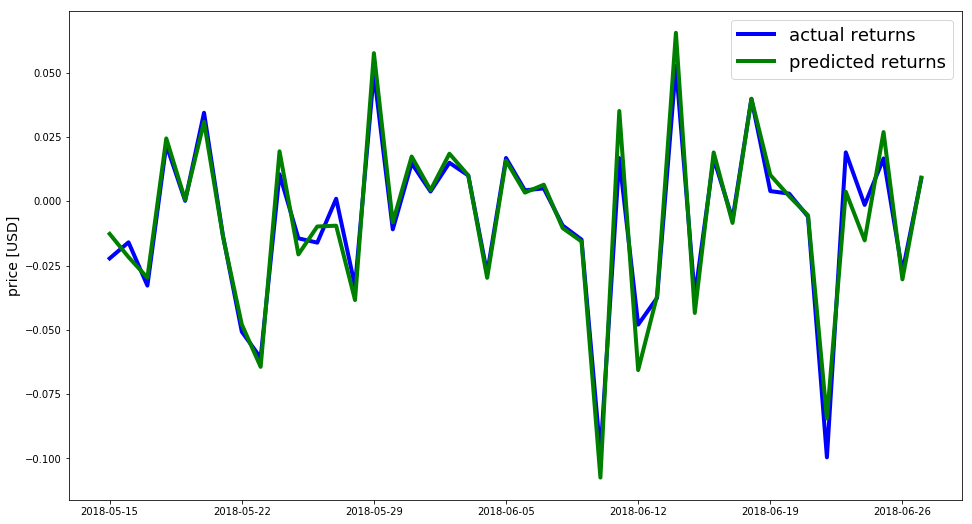

In [28]:
# Dual plots of actual returns vs. predicted returns
dual_line_plot(actual_returns[-n_points:],
          predicted_returns[-n_points:],
          actual_returns[-n_points:][:-1],
          predicted_returns[-n_points:].shift(-1),
          'actual returns', 'predicted returns', lw=4)

line_plot(actual_returns[-n_points:][:-1], predicted_returns[-n_points:].shift(-1),
           'actual returns', 'predicted returns', lw=4)

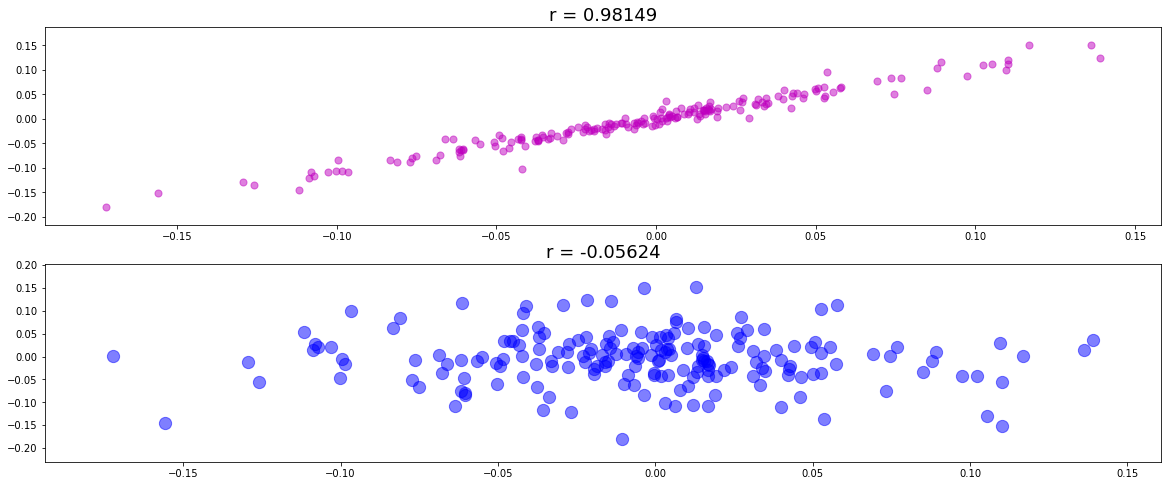

In [29]:
# Adjust the figure position and size.
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(20, 8))

# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='b', marker='o', alpha=0.5, s=150)
ax1.set_title('r = {:.5f}'.format(corr), fontsize=18)

# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='m', marker='o', alpha=0.5, s=50)
ax2.set_title('r = {:.5f}'.format(corr), fontsize=18);
